# 3. Network Lesion analysis:



*Yiyu Wang 2022 December*

In [1]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn import svm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import seaborn as sns

In [2]:
SEED = 2022
N_ROI = 100

# model params:
learning_rate = 1e-3
hidden_size = 150
feature_dim = N_ROI
output_size = 1
n_layers=2

# load the subjects:
included_data = pd.read_csv('/work/abslab/AVFP/Preproc_Scripts/included_AVFP_novel_subjects.csv', header=None)
subIDs = included_data[0].astype('str').tolist()

In [3]:

# copied from previous script:
class CustomAffVidsDynamicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

def GetDataName(subject, run='*'):
    file_name = glob.glob(f'/work/abslab/Yiyu/dnn/AVFP_parcellation/wholebrain_schaeffer_{N_ROI}/par-{subject}_run-{run}_schaefer_{N_ROI}.csv')
    if not file_name :
        raise Exception('No this parcellation csv file!')
    return file_name

def CreateXY(sub_list, network = None, y_col='fear'):
    """
    Run gradient descent to opimize parameters of a given network

    Args:
    sub_list: list
        list of subject IDs to extract the data
    network: str 
        which network to lesion, or default is no lesion 
        the network name must be in the dataframe column names
    y_col: str
        which column to extract the y variable
        default = 'fear'

    Returns:
    X_tensor: Tensor
        batch x seq x feature
    Y_tensor: Tensor
    """
    
    X = []
    Y = []
    for sub in sub_list:
        for parcellation_path in GetDataName(sub):
            par_df =pd.read_csv(parcellation_path)
            par_df = par_df.loc[par_df['video_name']!='0']
            
            if network:
                x_cols = [col for col in par_df.columns if 'Networks' in col]
                zero_cols = [col for col in x_cols if (network in col)]
                par_df[zero_cols]=0
                  
            avg = par_df[y_col].mean()
            std = par_df[y_col].std()
            for vid_name, trial_df in par_df.groupby('video_name'):
                if ~np.isnan(trial_df[y_col].unique()[0]):
                    X.append(trial_df.iloc[:,0:N_ROI].astype(float).values)
                    Y.append((trial_df[y_col].unique()[0]-avg)/std)

    # concate the x and y
    # x: batch x seq  x feature
    X_tensor = torch.tensor(np.array(X))
    # .permute(2, 1, 0)
    Y_tensor = torch.tensor(Y)
    return X_tensor, Y_tensor

# set up the RNN model:

class BrainLTSM_Classifier(nn.Module):
    def __init__(self, output_size, hidden_size, feature_dim, n_layers):
        super(BrainLTSM_Classifier, self).__init__()
        
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.feature_dim = feature_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(feature_dim, hidden_size, n_layers, batch_first=True,dropout=.2)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, inputs):
        # batch = len(inputs) (if batch_first = True)
        h0 = torch.randn(self.n_layers,len(inputs),self.hidden_size)
        c0 = torch.randn(self.n_layers,len(inputs),self.hidden_size)
        output,hidden = self.lstm(inputs,(h0, c0))
        
        output = self.linear(output)
        return output, hidden


In [5]:
def GetValLossAcc(model, loss_fn, test_dataloader,device='cpu'):
    
    #test_loss = []
    #test_acc = []
    
    model.eval()  
    with torch.no_grad():
        Y_shuffled, Y_preds = [],[]
        for X, Y in test_dataloader:
            X.to(device),Y.to(device)
            preds, hidden = model(X.float())
            test_loss = loss_fn(preds[:,-1,0], Y.float())

            #test_loss.append(epoch_test_loss.item())
            Y_shuffled.append(Y)
            Y_preds.append(preds)
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        test_accuracy = np.corrcoef(Y_shuffled.detach().numpy(),
                                      Y_preds.detach().squeeze().numpy()[:,-1])[0,1]  

    
    return test_loss, test_accuracy 
                

In [6]:
loss_fn = nn.MSELoss()
network_list = ['Vis','SomMot','DorsAttn','SalVent','Limbic','Cont','Default']
network_score_list = []
kf = KFold(n_splits=5, shuffle=True, random_state = SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
for network in network_list:
    print(f'\n lesion network = {network}')
    fold_acc_list = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(subIDs)):
        print(f'---------------------- fold {fold+1} ---------------------------')
        sub_test = np.array(subIDs)[test_idx.astype(int)].tolist()
        
        test_X, test_Y = CreateXY(sub_test, network = network)
        test_dataset = CustomAffVidsDynamicDataset(test_X, test_Y)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    
        model_file_path = f'models/LSTM_feature-{feature_dim}_hidden-{hidden_size}_layers-{n_layers}_fold-{fold}_lr-{learning_rate}.pt'
        # print(f'loading: {model_file_path}')
        
        model = BrainLTSM_Classifier(output_size, hidden_size, feature_dim, n_layers)
        model.load_state_dict(torch.load(model_file_path))
        
        test_loss, test_acc = GetValLossAcc(model, loss_fn, test_dataloader,device=device)
        fold_acc_list.append(test_acc)
    network_acc = np.mean(fold_acc_list)
    print(f'{network}: {network_acc}')
    network_score_list.append(network_acc)

network_score = pd.DataFrame({'network': network_list, 'lesion_score': network_score_list})
network_score.to_csv('lesion_network_score.csv')


 lesion network = Vis
---------------------- fold 1 ---------------------------
---------------------- fold 2 ---------------------------
---------------------- fold 3 ---------------------------
---------------------- fold 4 ---------------------------
---------------------- fold 5 ---------------------------
Vis: 0.21014974235829315

 lesion network = SomMot
---------------------- fold 1 ---------------------------
---------------------- fold 2 ---------------------------
---------------------- fold 3 ---------------------------
---------------------- fold 4 ---------------------------
---------------------- fold 5 ---------------------------
SomMot: 0.21467262843900312

 lesion network = DorsAttn
---------------------- fold 1 ---------------------------
---------------------- fold 2 ---------------------------
---------------------- fold 3 ---------------------------
---------------------- fold 4 ---------------------------
---------------------- fold 5 ---------------------------


<AxesSubplot:xlabel='network', ylabel='lesion_score'>

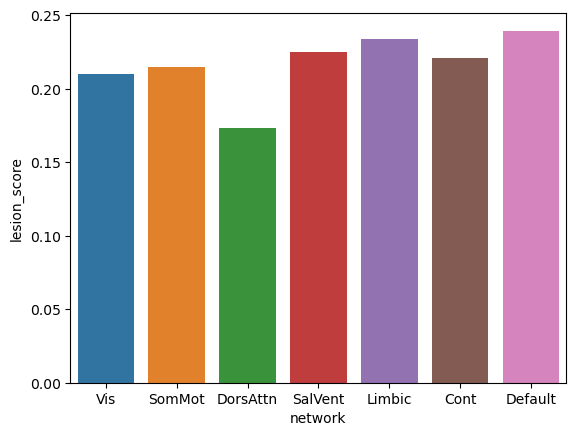

In [7]:
# quick visual:
sns.barplot(data=network_score, x="network", y="lesion_score")

The lower the score, suggesting the more impact "lesion" this network has on the prediction performace of the LSTM. 

Overall, the dorsal attention network contributes the most to predicting fear experiences